In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import RobertaTokenizer, RobertaModel  # 使用 RoBERTa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # 用于可视化
from tqdm import tqdm  # 用于显示训练进度条
from torch.optim.lr_scheduler import ReduceLROnPlateau  # 学习率调度器
from torch.utils.tensorboard import SummaryWriter  # 导入 TensorBoard 相关的库

In [2]:
# 自定义 collate_fn 处理变长输入
def collate_fn(batch):
    '''
    该函数用于将单个数据样本从 Dataset 中合并成一个批次。
    主要功能：
    1. 合并图像数据，使用 `torch.stack` 将图像样本堆叠成一个批次。
    2. 合并文本输入，处理每个文本的 `input_ids` 和 `attention_mask`，并做 padding 以保证输入长度一致。
    3. 合并标签，将标签转换为张量。
    '''
    images, text_inputs, labels = zip(*batch)
    
    # 图像批次处理：图像数据通常不会有变化，因此直接堆叠
    images = torch.stack(images, 0)
    
    # 获取最大文本长度，以便进行合理的填充
    max_input_length = max([len(text_input['input_ids'].squeeze(0)) for text_input in text_inputs])
    
    # 动态填充：只对当前批次中较长的文本进行填充，避免过多的冗余填充
    input_ids = [text_input['input_ids'].squeeze(0) for text_input in text_inputs]
    attention_mask = [text_input['attention_mask'].squeeze(0) for text_input in text_inputs]

    # 仅对每个文本填充至当前批次的最大长度
    for i in range(len(input_ids)):
        padding_length = max_input_length - input_ids[i].size(0)
        if padding_length > 0:  # 仅需要填充时执行
            input_ids[i] = torch.cat([input_ids[i], torch.zeros(padding_length, dtype=torch.long)], dim=0)
            attention_mask[i] = torch.cat([attention_mask[i], torch.zeros(padding_length, dtype=torch.long)], dim=0)

    # 堆叠文本输入（input_ids 和 attention_mask）
    input_ids = torch.stack(input_ids, dim=0)
    attention_mask = torch.stack(attention_mask, dim=0)

    # 转换标签为 Tensor
    labels = torch.tensor(labels)

    return images, {'input_ids': input_ids, 'attention_mask': attention_mask}, labels


device = torch.device("cpu")  # 我的电脑没有gpu环境

In [3]:
class MultiModalDataset(Dataset):
    '''
    该类用于加载和处理图像和文本数据。
    主要功能：
    1. 从文件夹中读取图像文件和文本文件。
    2. 使用指定的 RoBERTa 分词器处理文本数据。
    3. 从标签文件加载对应的标签，并将标签转换为数字形式（0, 1, 2）。
    '''
    def __init__(self, data_folder, label_file, tokenizer, transform=None):
        self.data_folder = data_folder
        self.tokenizer = tokenizer
        self.transform = transform

        self.data = pd.read_csv(label_file)
        self.guid_list = self.data["guid"].tolist()
        self.labels = self.data["tag"].map({"positive": 0, "neutral": 1, "negative": 2}).tolist()

    def __len__(self):
        return len(self.guid_list)

    def __getitem__(self, idx):
        '''
        获取指定索引的数据样本（图像、文本和标签）
        1. 加载图像文件。
        2. 使用 RoBERTa 分词器处理文本文件。
        3. 返回图像、文本的 RoBERTa 输入和标签。
        '''
        guid = self.guid_list[idx]
        image_path = os.path.join(self.data_folder, f"{guid}.jpg")
        text_path = os.path.join(self.data_folder, f"{guid}.txt")

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        with open(text_path, 'r', encoding='ISO-8859-1') as file:
            text = file.read()

        text_input = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

        label = self.labels[idx]
        return image, text_input, label

In [4]:
# 图像预处理，数据增强
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(30),  # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机颜色变化
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载 RoBERTa 的 tokenizer 和模型
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # 使用 roberta-base
# 使用 RoBERTa 模型
model_roberta = RobertaModel.from_pretrained('roberta-base')

# 数据集实例
data_folder = './data'
label_file = './train.txt'
dataset = MultiModalDataset(data_folder, label_file, tokenizer, transform)

# 划分训练集和验证集
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
class MultiModalModel(nn.Module): 
    '''
    该模型融合了 RoBERTa 和 ResNet50：
    1. RoBERTa 用于提取文本特征。
    2. ResNet50 用于提取图像特征。
    3. 图像特征和文本特征通过全连接层进行融合并分类。
    '''
    def __init__(self):
        super(MultiModalModel, self).__init__()

        # 使用预训练的 ResNet50 提取图像特征
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # 不需要全连接层

        # 使用预训练的 RoBERTa 提取文本特征
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.roberta_fc = nn.Linear(self.roberta.config.hidden_size, 768)

        # 融合图像和文本特征，通过全连接层进行分类
        self.fc = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)  # 输出3个类：positive, neutral, negative
        )

    def forward(self, image, text_input):
        '''
        前向传播：
        1. 图像特征通过 ResNet50 提取。
        2. 文本特征通过 RoBERTa 提取并映射到 768 维。
        3. 将图像特征和文本特征拼接并通过全连接层进行分类。
        '''
        image_features = self.resnet(image)
        text_output = self.roberta(**text_input)
        text_features = self.roberta_fc(text_output.pooler_output)

        combined_features = torch.cat((image_features, text_features), dim=1)
        output = self.fc(combined_features)
        return output

In [6]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    '''
    该函数用于绘制训练过程中的损失和准确率变化曲线。
    1. 绘制训练损失和验证损失的变化曲线。
    2. 绘制训练准确率和验证准确率的变化曲线。
    '''
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 创建 TensorBoard 记录器
writer = SummaryWriter(log_dir='./runs/experiment_1')  # 指定日志保存路径

def train_model(model, train_loader, val_loader, epochs=5, learning_rate=1e-5, save_path="model.pth"):
    '''
    该函数用于训练模型：
    1. 定义优化器和损失函数（交叉熵损失）。
    2. 每个 epoch 中计算训练损失和准确率。
    3. 评估模型在验证集上的表现。
    4. 保存训练过程中最好的模型。
    '''
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # 添加 L2 正则化（weight_decay）
    criterion = nn.CrossEntropyLoss()
    
    # 使用学习率调度器
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        # 使用 tqdm 显示训练进度条
        for images, text_inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", unit="batch"):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)

            text_inputs['input_ids'] = text_inputs['input_ids'].to(device)
            text_inputs['attention_mask'] = text_inputs['attention_mask'].to(device)

            outputs = model(images, text_inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracy = correct_train / total_train * 100
        train_accuracies.append(train_accuracy)

        # 验证集评估
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, text_inputs, labels in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}", unit="batch"):
                images, labels = images.to(device), labels.to(device)
                text_inputs['input_ids'] = text_inputs['input_ids'].to(device)
                text_inputs['attention_mask'] = text_inputs['attention_mask'].to(device)

                outputs = model(images, text_inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val / total_val * 100
        val_accuracies.append(val_accuracy)

        # 在 TensorBoard 中记录训练和验证损失与准确率
        writer.add_scalar('Training Loss', train_losses[-1], epoch)
        writer.add_scalar('Validation Loss', val_losses[-1], epoch)
        writer.add_scalar('Training Accuracy', train_accuracies[-1], epoch)
        writer.add_scalar('Validation Accuracy', val_accuracies[-1], epoch)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]:.2f}%")
        print(f"Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]:.2f}%")

        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

        # 更新学习率
        scheduler.step(val_losses[-1])

    # 绘制训练过程的损失和准确率曲线
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

    # 关闭 TensorBoard 记录器
    writer.close()

In [7]:
def test_model(model, test_loader, model_path="model.pth"):
    '''
    该函数用于在测试集上评估模型性能：
    1. 加载训练好的模型。
    2. 在测试集上进行前向传播，获取预测标签。
    '''
    model.load_state_dict(torch.load(model_path))
    model.eval()

    predictions = []
    with torch.no_grad():
        for images, text_inputs, _ in tqdm(test_loader, desc="Testing", unit="batch"):
            images = images.to(device)
            text_inputs['input_ids'] = text_inputs['input_ids'].to(device)
            text_inputs['attention_mask'] = text_inputs['attention_mask'].to(device)

            outputs = model(images, text_inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    return predictions


def generate_test_results(test_df, predictions, output_file="result.txt"):
    '''
    该函数用于生成测试集的结果文件：
    1. 将预测结果（标签）添加到测试数据框中。
    2. 将结果保存到指定的文件中（支持追加模式）。
    '''
    predictions_length = len(predictions)
    test_length = len(test_df)

    if predictions_length < test_length:
        predictions.extend([predictions[-1]] * (test_length - predictions_length))
    elif predictions_length > test_length:
        predictions = predictions[:test_length]

    test_df['tag'] = ['positive' if p == 0 else 'neutral' if p == 1 else 'negative' for p in predictions]

    if os.path.exists(output_file):
        test_df[['guid', 'tag']].to_csv(output_file, index=False, header=False, mode='a', sep=",")
        print(f"Appended results to {output_file}")
    else:
        test_df[['guid', 'tag']].to_csv(output_file, index=False, header=True, sep=",")
        print(f"Created {output_file} and added results")

E:\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
E:\python\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. 

Epoch 1/5, Train Loss: 0.8765447524003684, Train Accuracy: 60.78%
Validation Loss: 0.8439121453231201, Validation Accuracy: 63.12%
Model saved to model.pth


Validating Epoch 2/5: 100%|██████████| 400/400 [01:43<00:00,  3.87batch/s]


Epoch 2/5, Train Loss: 0.752145981953945, Train Accuracy: 67.41%
Validation Loss: 0.6883869412727655, Validation Accuracy: 72.25%
Model saved to model.pth


Validating Epoch 3/5: 100%|██████████| 400/400 [01:29<00:00,  4.45batch/s]


Epoch 3/5, Train Loss: 0.6086835673474706, Train Accuracy: 75.19%
Validation Loss: 0.7451830855803564, Validation Accuracy: 66.88%
Model saved to model.pth


Validating Epoch 4/5: 100%|██████████| 400/400 [01:30<00:00,  4.43batch/s]


Epoch 4/5, Train Loss: 0.47436886908719317, Train Accuracy: 81.88%
Validation Loss: 0.8105163441202603, Validation Accuracy: 67.12%
Model saved to model.pth


Validating Epoch 5/5: 100%|██████████| 400/400 [01:30<00:00,  4.44batch/s]


Epoch 5/5, Train Loss: 0.3518319985931157, Train Accuracy: 86.72%
Validation Loss: 0.891021683823783, Validation Accuracy: 70.25%
Model saved to model.pth


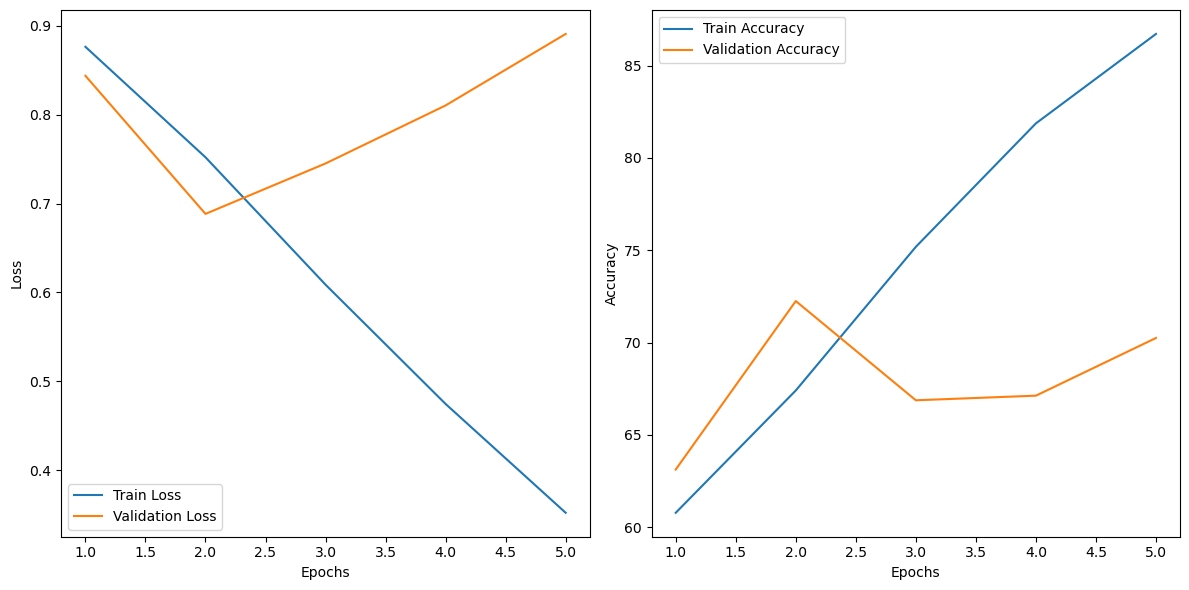

Testing: 100%|██████████| 256/256 [01:16<00:00,  3.33batch/s]

Created result.txt and added results


In [8]:
# 主程序：训练和测试
if __name__ == "__main__":
    '''
    该部分代码是主程序入口：
    1. 加载并处理测试集数据。
    2. 创建数据加载器。
    3. 初始化模型，训练并保存模型。
    4. 使用训练好的模型在测试集上进行预测，并生成结果文件。
    '''
    test_file = './test_without_label.txt'
    test_df = pd.read_csv(test_file, header=None, names=["guid", "tag"], skipinitialspace=True)

    test_dataset = MultiModalDataset(data_folder, test_file, tokenizer, transform)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

    model = MultiModalModel().to(device)

    # 训练模型
    train_model(model, train_loader, val_loader, epochs=5, learning_rate=1e-5)

    model.load_state_dict(torch.load("model.pth"))

    predictions = test_model(model, test_loader, model_path="model.pth")

    generate_test_results(test_df, predictions, output_file="result.txt")